# Project 1: Gradient-based Algorithms and Differentiable Programming



## 1. Introduction

The given project's objective is demonstrated with the below mentioned formulation considering a simlpe case of optimizing the trajectory for a rocket landing.

Consider a simple formulation of rocket landing where the rocket state $x(t)$ is represented by its distance to the ground $d(t)$ and its velocity $v(t)$, i.e., $x(t) = [d(t), v(t)]^T$, where $t$ specifies time. The control input of the rocket is its acceleration $a(t)$. The discrete-time dynamics follows

$$
\begin{aligned}
d(t+1) = d(t) + v(t) \Delta t, \\
v(t+1) = v(t) + a(t) \Delta t,
\end{aligned}
$$
where $\Delta t$ is a time interval. Further, let the closed-loop controller be

$$
a(t) = f_{\theta}(x(t))
$$
where $f_{\theta}(\cdot)$ is a neural network with parameters $\theta$, which are to be determined through optimization.

For each time step, we assign a loss as a function of the control input and the state: $l(x(t),a(t))$. In this example, we will simply set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(x(T),a(T)) = ||x(T)||^2 = d(T)^2 + v(T)^2$. This loss encourages the rocket to reach $d(T)=0$ and $v(T)=0$, which are proper landing conditions.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{\theta} \quad &amp; ||x(T)||^2 \\
\quad  d(t+1) = d(t) + v(t) \Delta t, \\
\quad  v(t+1) = v(t) + a(t) \Delta t, \\
\quad  a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1
\end{aligned}
$$
While this problem is constrained, it is easy to see that the objective function can be expressed as a function of $x(T-1)$ and $a(T-1)$, where $x(T-1)$ as a function of $x(T-2)$ and $a(T-2)$, and so on. Thus it is essentially an unconstrained problem with respect to $\theta$.

In the following, we code this problem up with PyTorch, which allows us to only build the forward pass of the loss (i.e., how we move from $x(1)$ to $x(2)$ and all the way to $x(T)$) and automatically get the gradient $\nabla_{\theta} l(x(T),a(T))$.



## 2. Problem formulation

In this problem, we consider a formulation of a rocket landing. The rocket state is $ x(t) $, angular velocity $ \omega(t) $, orientation $ \theta(t), $velocity $ v(t) $, and the distance of rocket to the platform $ d(t) $. The model also takes drag force into consideration by adding it to the state value. The control inputs are angular acceleration $ \alpha(t) $ and acceleration $ a(t) $.

### Objective Function

Therefore, the optimization problem is modeled as 
$$
\begin{array} \\
    {\min_{\theta}} & ||x(T)||^2\\
    & d(t+1) = d(t) + v(t)\cos(\theta){\Delta}t\\
    & a(t) = f_i(x(t)) + a_{drag}, \forall  t = 1, ..., T-1\\
    & v(t+1) = v(t) + a(t)\cos(\theta){\Delta}t\\ 
    & \alpha(t) = f_j(\theta(t)), \forall t = 1, ..., T-1\\
    & \theta(t+1) = \theta(t) + \omega(t){\Delta}t\\
    & \omega(t+1) = \omega(t) + \alpha(t){\Delta}t\\
\end{array}
$$

The problem is unconstrained w.r.t $ i $ and $ j $.
The goal is to land the rocket at time $ T = T_{final} $ with $ d(t) = v(t) = \theta(t) = \omega(t) = 0 $.

## 2. Programming

In [44]:
#Importing Libraries

import logging
from math import *
import random as r
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [45]:
#Environment Parameters
#Assumed to be constant and normalized

GRAVITY_ACCEL = 0.01  # gravity constant
FRAME_TIME = 0.1  # time interval
BOOST_ACCEL = 0.18  # assuming thrust constant
ROT_ACCEL = 0.10 # angular acceleration
DRAG_DECEL = 0.05 # acceleration due to drag

In [46]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action : thrust or no thrust
        state[0] = y
        state[1] = y_dot
        state[2] = theta
        state[3] = theta_dot

        """
        
        #Gravity
        delta_stateg = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME, 0., 0.])
        
        #Drag
        delta_stated = t.tensor([0., -DRAG_DECEL * FRAME_TIME, 0., 0.])
        
        #Orientation
        delta_stateo = t.tensor([0., BOOST_ACCEL * FRAME_TIME * cos(state[2]), 0., 0.]) * action[0]
        
        #Rotaional Acceleration
        delta_stater = t.tensor([0., 0., 0., ROT_ACCEL * FRAME_TIME]) * action[1]

        # Update velocity
        state = state + delta_stateo + delta_stateg + delta_stater + delta_stated
        
        # Update state
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0.],
                            [0., 1., 0., 0.],
                            [0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 1.]])
        state = t.matmul(step_mat, state)

        return state

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Tanh()
        )

    def forward(self, state):
        action = self.network(state)
        return action

class Simulation(nn.Module):
    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    #Initial State
    @staticmethod
    def initialize_state():
        state = [2.5, 0., -1.5, 0.]  #Initial states
        return t.tensor(state, requires_grad=False).float()

    #Error
    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2

____________________________________________________________________________________________________________

Iteration number:	 1
loss: 2.973


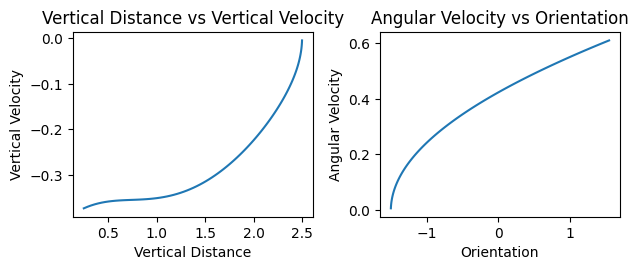

____________________________________________________________________________________________________________

Iteration number:	 2
loss: 1.167


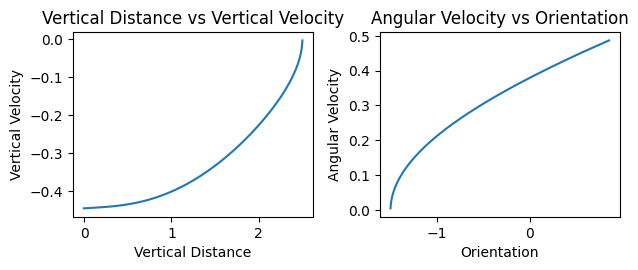

____________________________________________________________________________________________________________

Iteration number:	 3
loss: 0.741


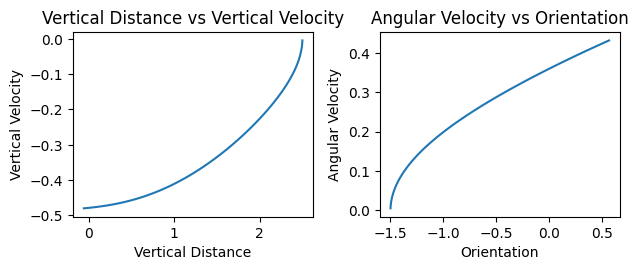

____________________________________________________________________________________________________________

Iteration number:	 4
loss: 0.568


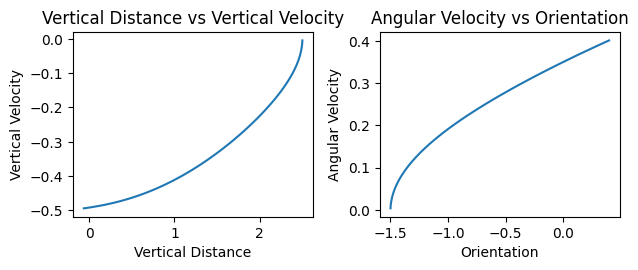

____________________________________________________________________________________________________________

Iteration number:	 5
loss: 0.475


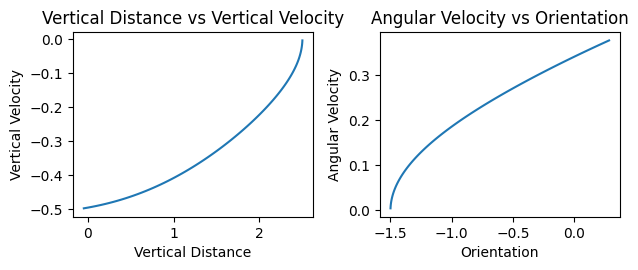

____________________________________________________________________________________________________________

Iteration number:	 6
loss: 0.419


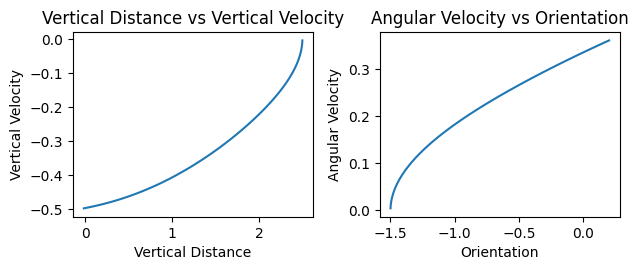

____________________________________________________________________________________________________________

Iteration number:	 7
loss: 0.385


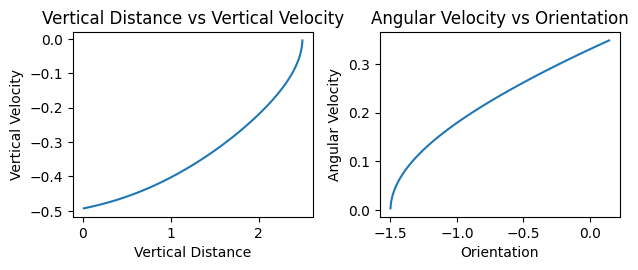

____________________________________________________________________________________________________________

Iteration number:	 8
loss: 0.363


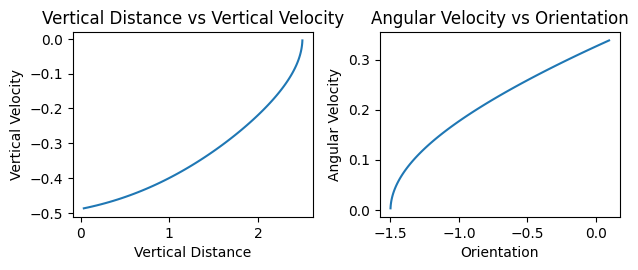

____________________________________________________________________________________________________________

Iteration number:	 9
loss: 0.347


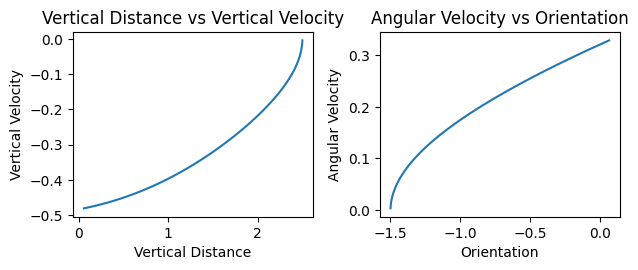

____________________________________________________________________________________________________________

Iteration number:	 10
loss: 0.334


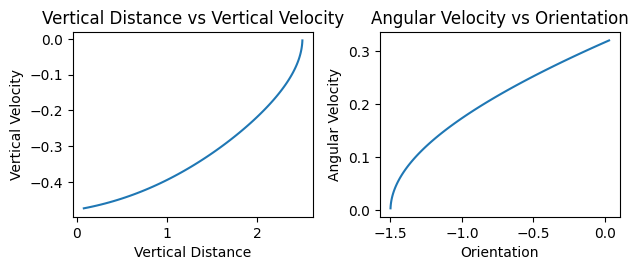

____________________________________________________________________________________________________________

Iteration number:	 11
loss: 0.321


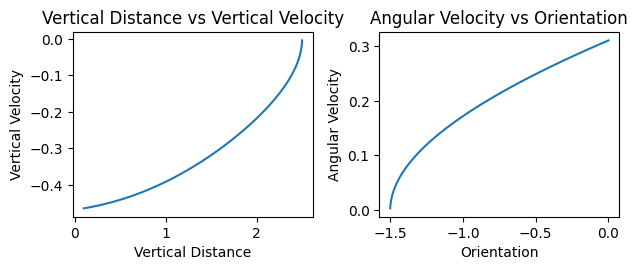

____________________________________________________________________________________________________________

Iteration number:	 12
loss: 0.310


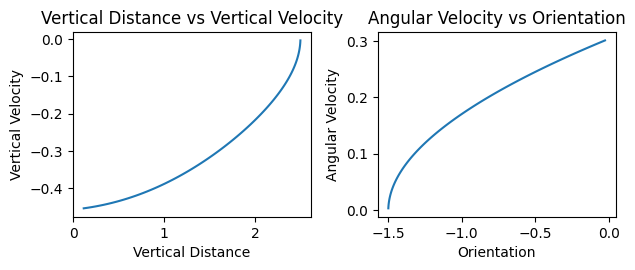

____________________________________________________________________________________________________________

Iteration number:	 13
loss: 0.296


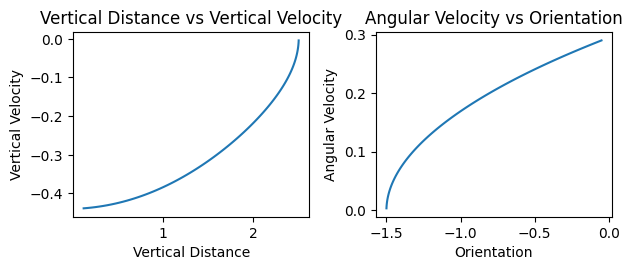

____________________________________________________________________________________________________________

Iteration number:	 14
loss: 0.255


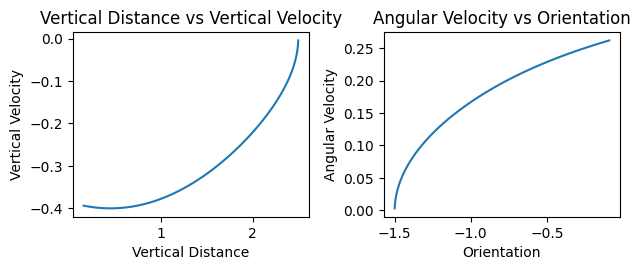

____________________________________________________________________________________________________________

Iteration number:	 15
loss: 0.119


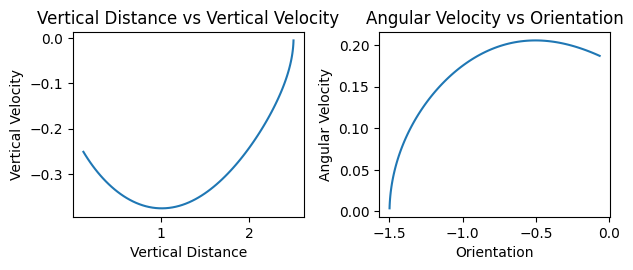

____________________________________________________________________________________________________________

Iteration number:	 16
loss: 0.083


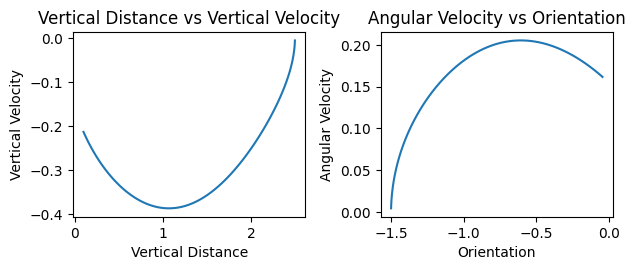

____________________________________________________________________________________________________________

Iteration number:	 17
loss: 0.059


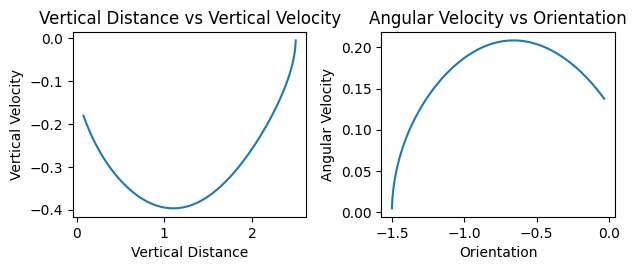

____________________________________________________________________________________________________________

Iteration number:	 18
loss: 0.040


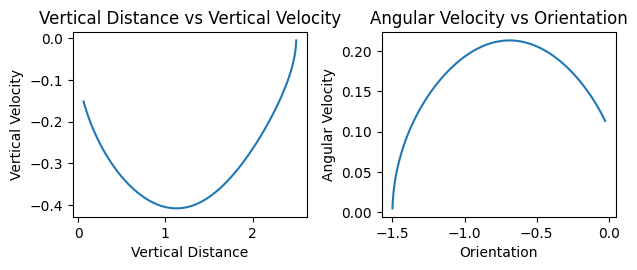

____________________________________________________________________________________________________________

Iteration number:	 19
loss: 0.027


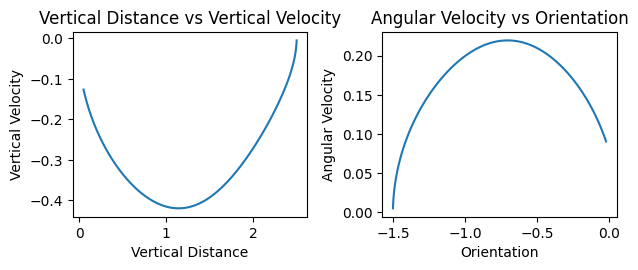

____________________________________________________________________________________________________________

Iteration number:	 20
loss: 0.018


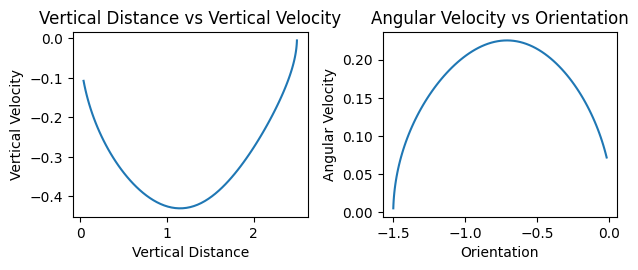

____________________________________________________________________________________________________________

Iteration number:	 21
loss: 0.013


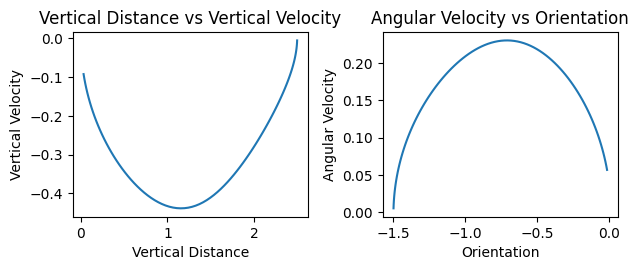

____________________________________________________________________________________________________________

Iteration number:	 22
loss: 0.009


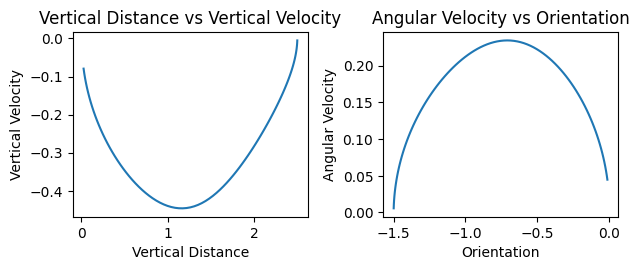

____________________________________________________________________________________________________________

Iteration number:	 23
loss: 0.006


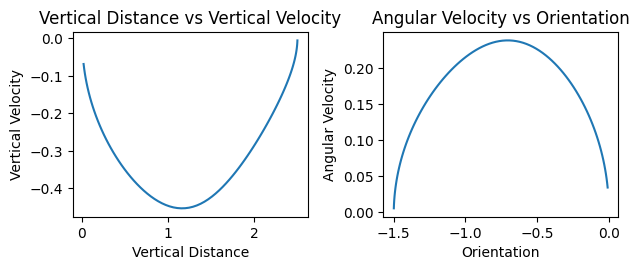

____________________________________________________________________________________________________________

Iteration number:	 24
loss: 0.004


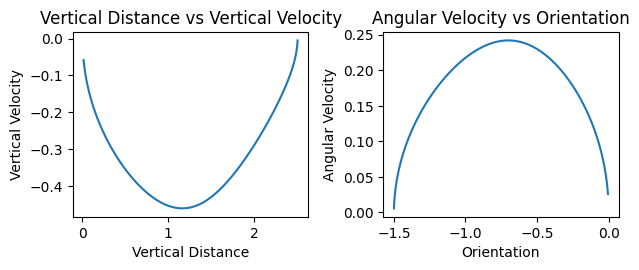

____________________________________________________________________________________________________________

Iteration number:	 25
loss: 0.003


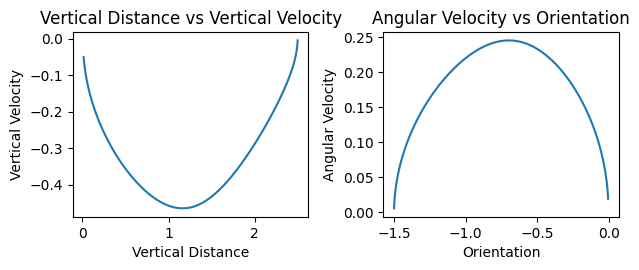

____________________________________________________________________________________________________________

Iteration number:	 26
loss: 0.002


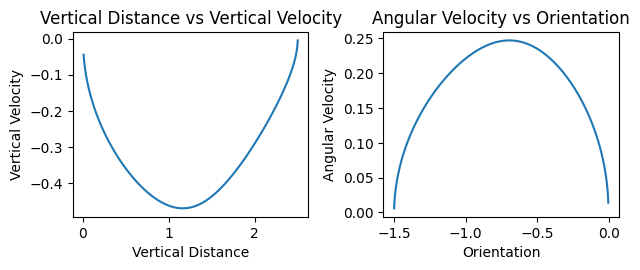

____________________________________________________________________________________________________________

Iteration number:	 27
loss: 0.002


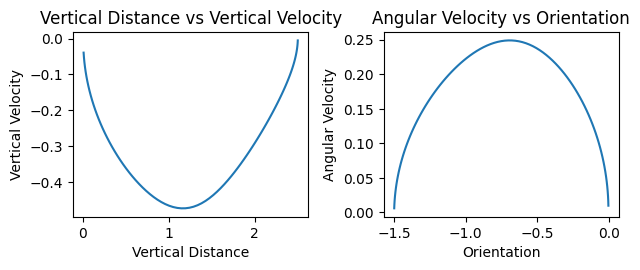

____________________________________________________________________________________________________________

Iteration number:	 28
loss: 0.001


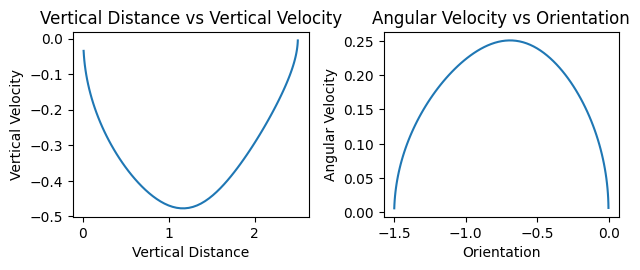

____________________________________________________________________________________________________________

Iteration number:	 29
loss: 0.001


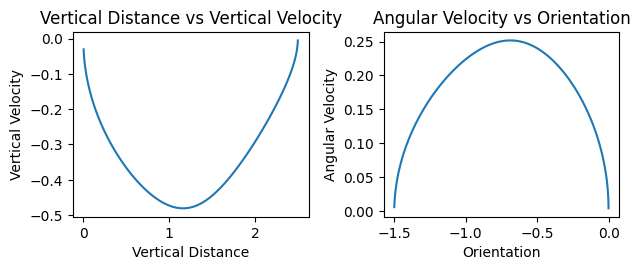

____________________________________________________________________________________________________________

Iteration number:	 30
loss: 0.001


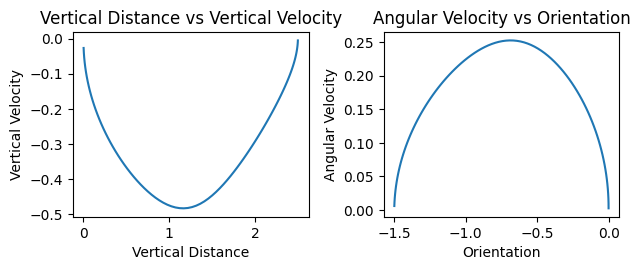

____________________________________________________________________________________________________________

Iteration number:	 31
loss: 0.001


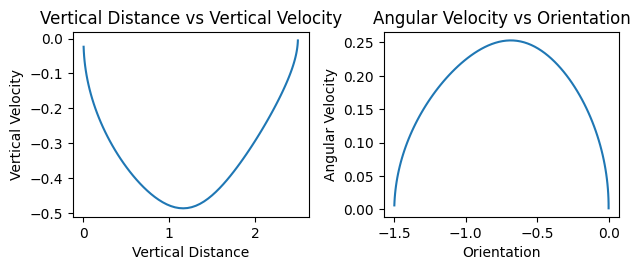

____________________________________________________________________________________________________________

Iteration number:	 32
loss: 0.000


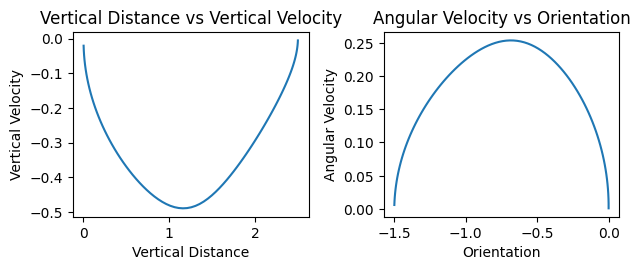

____________________________________________________________________________________________________________

Iteration number:	 33
loss: 0.000


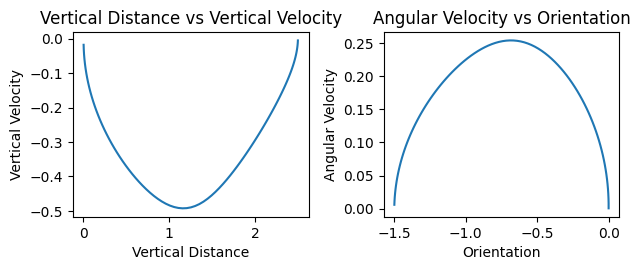

____________________________________________________________________________________________________________

Iteration number:	 34
loss: 0.000


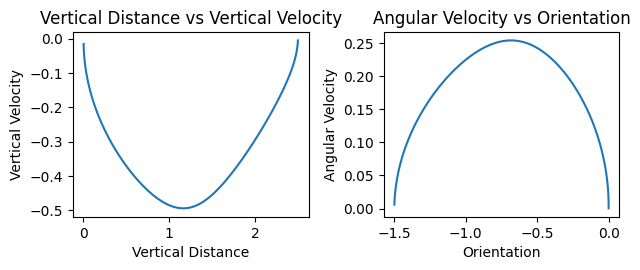

____________________________________________________________________________________________________________

Iteration number:	 35
loss: 0.000


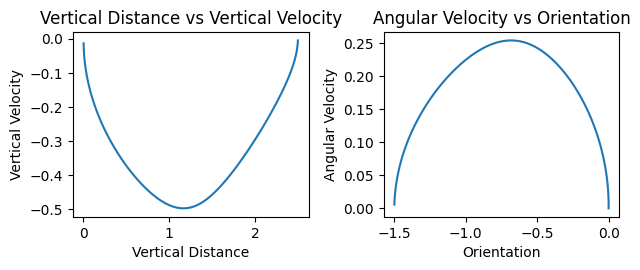

____________________________________________________________________________________________________________

Iteration number:	 36
loss: 0.000


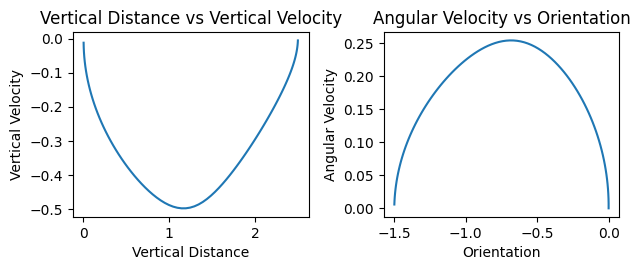

____________________________________________________________________________________________________________

Iteration number:	 37
loss: 0.000


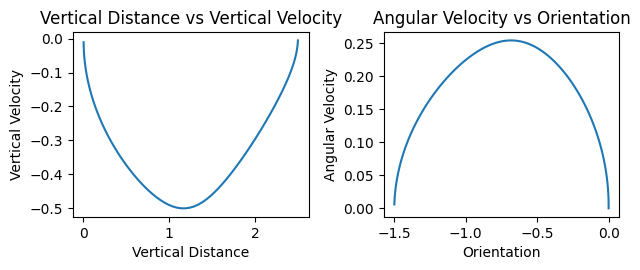

____________________________________________________________________________________________________________

Iteration number:	 38
loss: 0.000


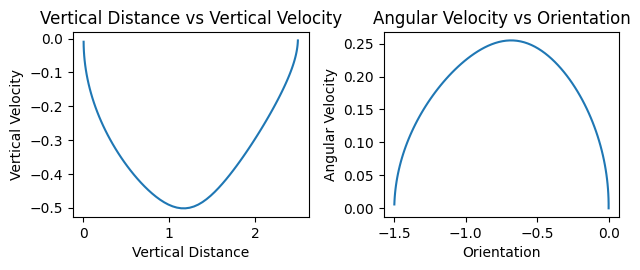

____________________________________________________________________________________________________________

Iteration number:	 39
loss: 0.000


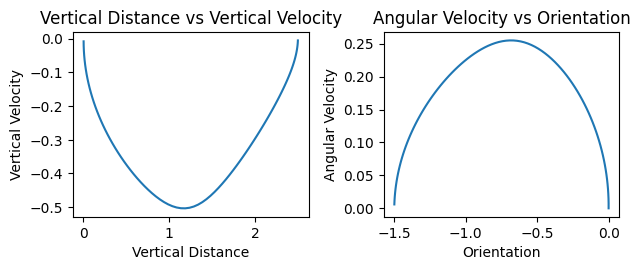

____________________________________________________________________________________________________________

Iteration number:	 40
loss: 0.000


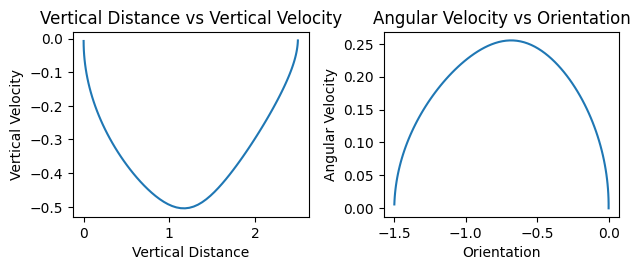

____________________________________________________________________________________________________________

Iteration number:	 41
loss: 0.000


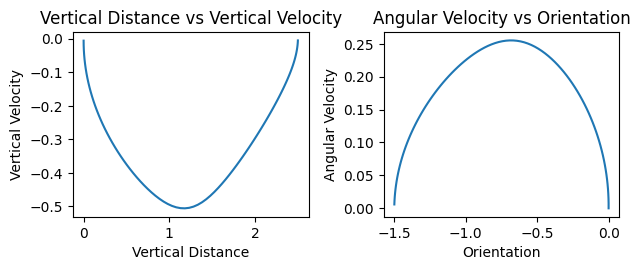

____________________________________________________________________________________________________________

Iteration number:	 42
loss: 0.000


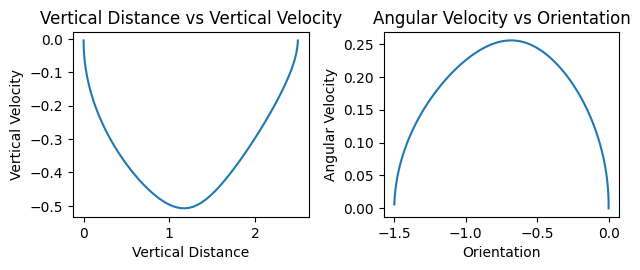

____________________________________________________________________________________________________________

Iteration number:	 43
loss: 0.000


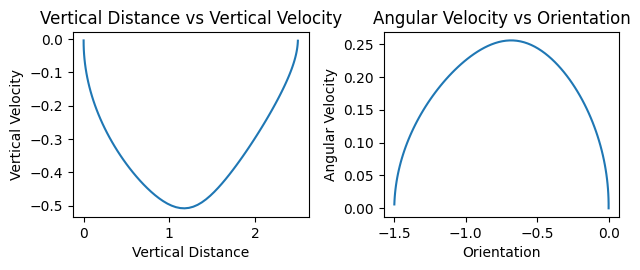

____________________________________________________________________________________________________________

Iteration number:	 44
loss: 0.000


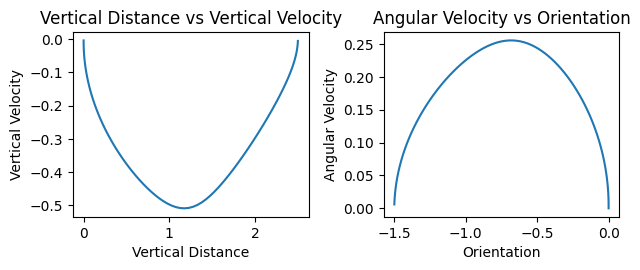

____________________________________________________________________________________________________________

Iteration number:	 45
loss: 0.000


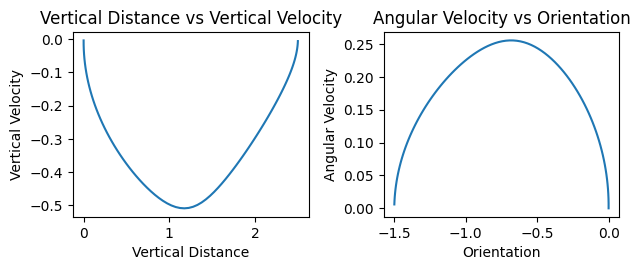

____________________________________________________________________________________________________________

Iteration number:	 46
loss: 0.000


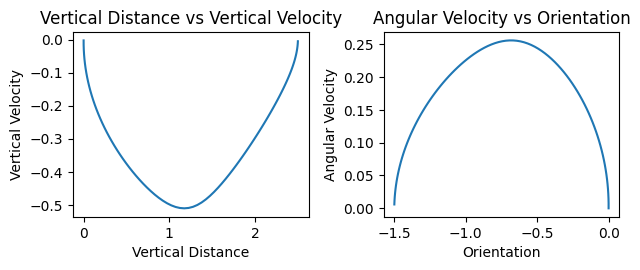

____________________________________________________________________________________________________________

Iteration number:	 47
loss: 0.000


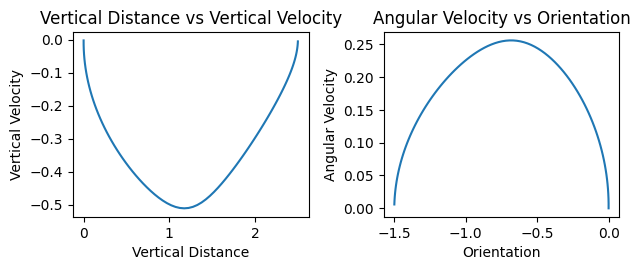

____________________________________________________________________________________________________________

Iteration number:	 48
loss: 0.000


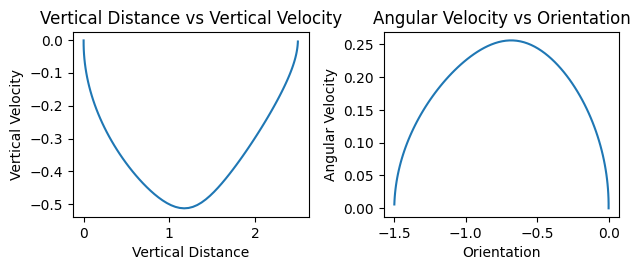

____________________________________________________________________________________________________________

Iteration number:	 49
loss: 0.000


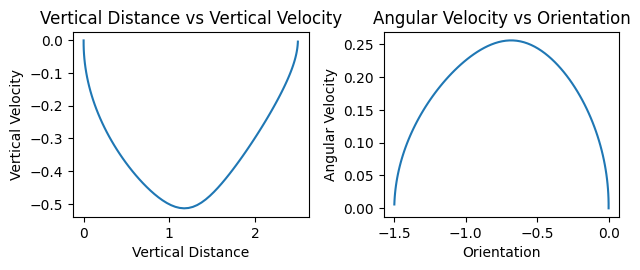

____________________________________________________________________________________________________________

Iteration number:	 50
loss: 0.000


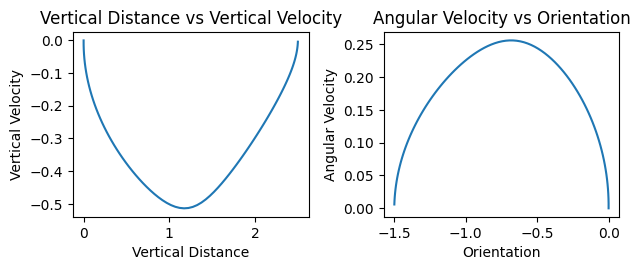

In [47]:
class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('____________________________________________________________________________________________________________')
            print('\nIteration number:\t',epoch+1)
            print('loss: %.3f' % (loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        a = data[:, 2]
        b = data[:, 3]
        
        plt.figure()
        plt.subplot(221)
        plt.title('Vertical Distance vs Vertical Velocity')
        plt.xlabel('Vertical Distance')
        plt.ylabel('Vertical Velocity')
        plt.plot(x, y)
        
        plt.subplot(222)
        plt.title('Angular Velocity vs Orientation')
        plt.xlabel('Orientation')
        plt.ylabel('Angular Velocity')
        plt.plot(a, b)
        plt.tight_layout()
        plt.show()

#Parameter to run the code
T = 100  # number of time steps
dim_input = 4  # state space dimensions (y, y_dot, theta, theta_dot)
dim_hidden = 8  # latent dimensions
dim_output = 2  # action space dimensions (a_y, alpha)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(50)  # solve

## 3. Analysis of the results

The code run for 50 iterations. From the above plots between vertical velocity and distance & orientaion and the angle the following conclusion can be made-

1. In the 1st iteration, We have a very high loss.

2. A major decrease in loss is evident up to 14th iteration.

3. After 15th iteration a constant loss can be seen until convergence is met.

4. The solution converges at 32nd iteration with a 0% loss because  $ d(t) = v(t) = \theta(t) = \omega(t) \approx 0 $.